In [1]:
! pip install -r requirements.txt

  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/8d/29/076999b69bd9264b8df5e56f2be18da2de6b2a2d0e10737e5307592e01de/numpy-2.2.3-cp311-cp311-macosx_14_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 483.5 kB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/61/d8/84da3fffefb6c7d5a16968fe5b9f24c98606b165bb801bb0b8bc3985200f/scipy-1.15.2-cp311-cp311-macosx_14_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:0000:01
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/25/92/ee1d7a00bb6b8c55755d4984fd82608603a3cc59959245068ce32e7fb808/scikit_learn-1.6.1-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/0a/e4/300b08e3e08f9c98b0d5635f42edabf2f7a1d634e64cb0318a71a44ff720/matplotlib-3

In [191]:
import polars as pl
from matplotlib import pyplot as plt 
import numpy as np 
import pylink 
import scipy
import time
import matplotlib as mpl
from scipy.stats import Normal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [170]:
# read RTT output for <num_seconds> and redirect to file <filename>
def rtt_to_file(filename, num_seconds):
    POLL_FREQ = 10.
    max_count = num_seconds * POLL_FREQ
    count = 0

    jlink = pylink.JLink()
    jlink.open()
    jlink.set_tif(pylink.enums.JLinkInterfaces.SWD)
    jlink.set_speed(10_000)
    jlink.connect("MKL03Z32XXX4")
    jlink.rtt_start()
    
    with open(filename, 'w') as f:
        while jlink.connected():
            try:
                terminal_bytes = jlink.rtt_read(0, 4096)
                if terminal_bytes:
                    s = "".join(map(chr, terminal_bytes))
                    print(f"writing {len(s)} bytes to file")
                    f.write(s)
                count += 1
                if count >= max_count:
                    jlink.close()
                    return
                time.sleep(1. / POLL_FREQ)
            except Exception as e:
                jlink.close()
                raise e

In [171]:
rtt_to_file("data/sitting.json", 120)

writing 320 bytes to file
writing 787 bytes to file
writing 665 bytes to file
writing 891 bytes to file
writing 729 bytes to file
writing 891 bytes to file
writing 729 bytes to file
writing 701 bytes to file
writing 695 bytes to file
writing 859 bytes to file
writing 773 bytes to file
writing 704 bytes to file
writing 777 bytes to file
writing 619 bytes to file
writing 480 bytes to file
writing 887 bytes to file
writing 648 bytes to file
writing 810 bytes to file
writing 729 bytes to file
writing 729 bytes to file
writing 891 bytes to file
writing 765 bytes to file
writing 689 bytes to file
writing 756 bytes to file
writing 686 bytes to file
writing 766 bytes to file
writing 688 bytes to file
writing 533 bytes to file
writing 80 bytes to file
writing 801 bytes to file
writing 729 bytes to file
writing 810 bytes to file
writing 810 bytes to file
writing 810 bytes to file
writing 729 bytes to file
writing 710 bytes to file
writing 687 bytes to file
writing 849 bytes to file
writing 694 b

In [172]:
df = pl.read_ndjson("data/sitting.json")
df.head()

type,group,sample_num,Re,Im,Mag
str,i64,i64,i64,i64,i64
"""TIME""",0,0,8576,0,8576
"""TIME""",0,1,8579,0,8579
"""TIME""",0,2,8583,0,8583
"""TIME""",0,3,8598,0,8598
"""TIME""",0,4,8608,0,8608


In [173]:
TIME_SCALE = 8192.
FREQ_SCALE = 4096.

In [244]:
# assumes magnitudes are of shape 64
def downsample_fft(magnitudes):
    output = np.zeros(7)
    output[0] = magnitudes[0]
    for i in range(6):
        output[i+1] = np.sum(magnitudes[(5*i)+1:1+5*(i+1)])
    return output

def klo3_downsample(magnitudes):
    output = np.zeros(7)
    output[0] = magnitudes[0]
    for i in range(1, 31):
        output[((i - 1) // 5) + 1] += magnitudes[i]
    return output

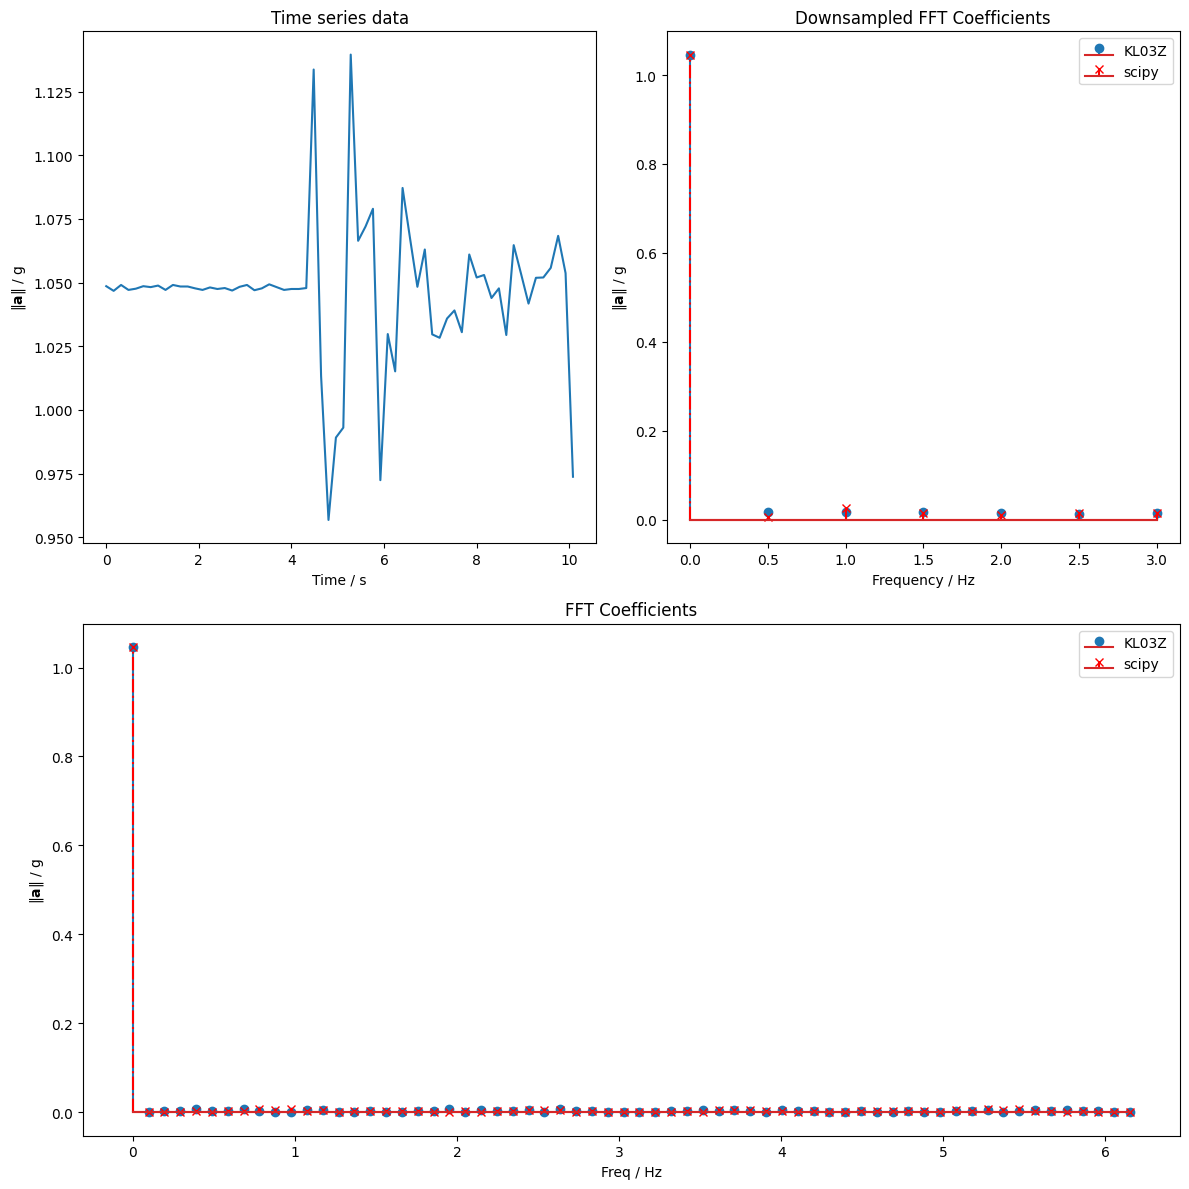

In [233]:
group = df.select(pl.col("group").sample(1)).item()
time_series = df.filter(
    (pl.col("group") == group) & (pl.col("type") == "TIME")
).sort("sample_num")
coefficients = df.filter(
    (pl.col("group") == group) & (pl.col("type") == "FREQ")
).sort("sample_num")

# fig, axs = plt.subplots(2, 1, figsize=(15, 15))
fig, axs = plt.subplot_mosaic([["A", "B"],
                               ["C", "C"]], 
                              figsize=(12, 12))

ax1 = axs["A"]
ax2 = axs["B"]
ax3 = axs["C"]

time_x = time_series["sample_num"].to_numpy() / 6.25
freq_x = coefficients["sample_num"].to_numpy() * 6.25 / 64.

time_y = time_series["Mag"].to_numpy() / TIME_SCALE
freq_y = coefficients["Mag"].to_numpy() / FREQ_SCALE
coefs = np.absolute(
    scipy.fft.fft(time_series["Mag"].to_numpy() / TIME_SCALE, norm="forward")
)

ax1.plot(time_x, time_y)
ax1.set_title("Time series data")
ax1.set_xlabel("Time / s")
ax1.set_ylabel("$\\|\\mathbf{a}\\|$ / g")

downsample_x = np.linspace(0, 3, 7)
ax2.stem(downsample_x, downsample_fft(freq_y), label="KL03Z")
ax2.stem(downsample_x, downsample_fft(coefs), label="scipy", linefmt="-.r", markerfmt="xr")
ax2.set_title("Downsampled FFT Coefficients")
ax2.set_xlabel("Frequency / Hz")
ax2.set_ylabel("$\\|\\mathbf{a}\\|$ / g")
ax2.legend()

ax3.stem(freq_x, freq_y, label="KL03Z")
ax3.stem(freq_x, coefs, label="scipy", linefmt="-.r", markerfmt="xr")
ax3.set_title("FFT Coefficients")
ax3.set_xlabel("Freq / Hz")
ax3.set_ylabel("$\\|\\mathbf{a}\\|$ / g")
ax3.legend()

fig.tight_layout()
plt.show()

walking -> 12 samples
stationary -> 95 samples
jogging -> 12 samples
sitting -> 12 samples


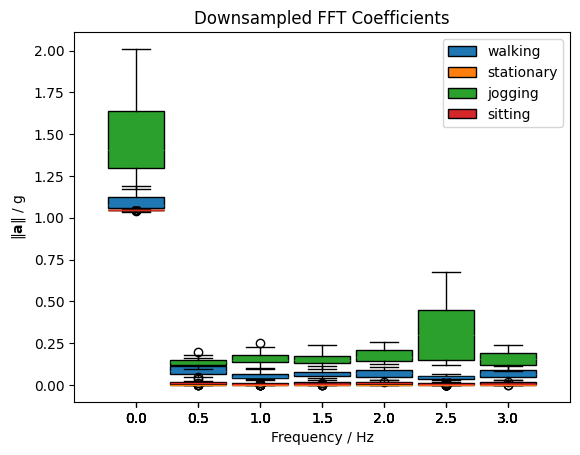

In [236]:
colors = mpl.colormaps["tab10"]
distrubutions = {}
samples = {}

FILENAMES = ["walking", "stationary", "jogging", "sitting"]

for (i, filename) in enumerate(FILENAMES):
    df = pl.read_ndjson(f"data/{filename}.json")
    downsampled = []
    groups = df.select(pl.col("group").unique())["group"].to_list()
    for group in groups:
        coefficients = df.filter(
            (pl.col("group") == group) & (pl.col("type") == "FREQ")
        ).sort("sample_num")["Mag"].to_numpy()
        downsampled.append(downsample_fft(coefficients))

    samples[filename] = downsampled
    downsampled = np.array(downsampled)
    print(f"{filename} -> {downsampled.shape[0]} samples")

    distrubutions[filename] = np.mean(downsampled, axis=0), np.std(downsampled, axis=0)
    
    bplot = plt.boxplot(downsampled / FREQ_SCALE, 
                         positions=np.linspace(0, 3.0, 7), 
                         patch_artist=True,
                         medianprops={"color": colors(i)},
                         label=filename)
    
    for patch in bplot['boxes']:
        patch.set_facecolor(colors(i))

plt.legend()
plt.title("Downsampled FFT Coefficients")
plt.xlabel("Frequency / Hz")
plt.ylabel("$\\|\\mathbf{a}\\|$ / g")
plt.show()

In [237]:
def classify(sample, data):
    probs = {}
    dist = Normal(mu=0, sigma=1)
    total = 0.
    
    for label, (mean, std) in data.items():
        acc = 1.
        for (i, x_i) in enumerate(sample):
            scaled = abs((x_i - mean[i]) / std[i])
            p = 1. - dist.cdf(scaled)
            acc *= p
        
        probs[label] = acc
        total += acc 
        
    inference = {}
    for label, prob in probs.items():
        inference[label] = prob / total
          
    return inference

In [238]:
data = []
for filename in FILENAMES:
    for sample in samples[filename]:
        output = classify(sample, distrubutions)
        output["label"] = filename 
        data.append(output)

inference = pl.from_dicts(data)
inference.head()

walking,stationary,jogging,sitting,label
f64,f64,f64,f64,str
0.999998,0.0,0.000002,0.0,"""walking"""
0.999995,0.0,0.000005,0.0,"""walking"""
1.0,0.0,1.9648e-7,0.0,"""walking"""
0.999999,0.0,8.1685e-7,0.0,"""walking"""
1.0,0.0,2.0044e-7,0.0,"""walking"""


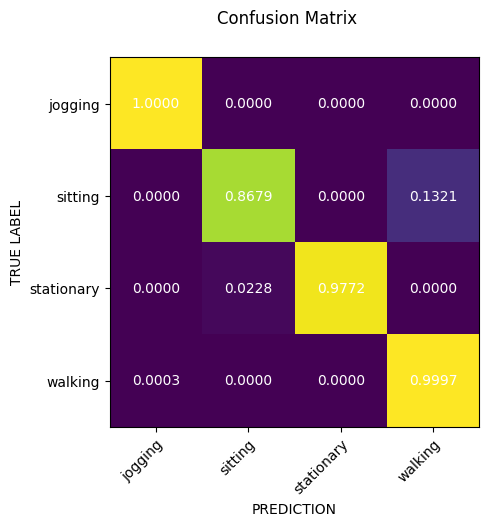

In [239]:
cm = (inference
    .group_by("label")
    .agg(pl.all().mean())
    .sort("label")
    .select(sorted(inference.columns))
    .select(pl.all().exclude("label")))

fig, ax = plt.subplots()
m = cm.to_numpy()
ax.imshow(m)
ax.set_xticks(range(len(cm.columns)), labels=cm.columns, rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(cm.columns)), labels=cm.columns)
ax.set_xlabel("PREDICTION")
ax.set_ylabel("TRUE LABEL")

for i in range(len(cm.columns)):
    for j in range(len(cm.columns)):
        ax.text(j, i, f"{m[i, j]:.4f}", ha="center", va="center", color="w")

fig.suptitle("Confusion Matrix")
plt.show()

In [243]:
for k, (mean, std) in distrubutions.items():
    print(k)
    print(",".join([str(x) for x in mean.astype(np.int16)]))
    print(",".join([str(x) for x in std.astype(np.int16)]))
    print("--------")

walking
4475,394,222,279,286,178,277
201,185,75,85,107,58,104
--------
stationary
4279,1,1,1,2,1,2
2,5,5,3,7,9,7
--------
jogging
6046,525,656,628,745,1316,654
1039,149,170,157,178,719,183
--------
sitting
4283,59,43,48,51,38,53
9,49,32,35,31,29,39
--------


In [260]:
dist = Normal(mu=0, sigma=1)
cdf = dist.cdf(np.arange(0, 3 << 7, 1).astype(np.float64) / 128.)
((1. - cdf) * 1024).astype(np.int16)

array([512, 508, 505, 502, 499, 496, 492, 489, 486, 483, 480, 476, 473,
       470, 467, 464, 461, 457, 454, 451, 448, 445, 442, 438, 435, 432,
       429, 426, 423, 420, 417, 414, 410, 407, 404, 401, 398, 395, 392,
       389, 386, 383, 380, 377, 374, 371, 368, 365, 362, 359, 356, 353,
       350, 347, 344, 341, 338, 335, 333, 330, 327, 324, 321, 318, 315,
       313, 310, 307, 304, 301, 299, 296, 293, 291, 288, 285, 282, 280,
       277, 275, 272, 269, 267, 264, 261, 259, 256, 254, 251, 249, 246,
       244, 241, 239, 236, 234, 232, 229, 227, 224, 222, 220, 217, 215,
       213, 210, 208, 206, 204, 201, 199, 197, 195, 193, 191, 188, 186,
       184, 182, 180, 178, 176, 174, 172, 170, 168, 166, 164, 162, 160,
       158, 156, 154, 152, 151, 149, 147, 145, 143, 142, 140, 138, 136,
       135, 133, 131, 130, 128, 126, 125, 123, 121, 120, 118, 117, 115,
       114, 112, 111, 109, 108, 106, 105, 103, 102, 101,  99,  98,  96,
        95,  94,  92,  91,  90,  89,  87,  86,  85,  84,  82,  8